In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, average_precision_score
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import ADASYN

In [48]:
# Load data
data = pd.read_csv('../dataset_tables/final_dataset.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      251 non-null    object
 1   split   251 non-null    object
 2   Label   251 non-null    bool  
 3   NDVI    251 non-null    object
 4   NBR     251 non-null    object
 5   NDWI    251 non-null    object
 6   NDBI    251 non-null    object
 7   RGB     251 non-null    object
dtypes: bool(1), object(7)
memory usage: 14.1+ KB


In [49]:
def convert_string_to_list(item):
    if isinstance(item, (int, float)):
        return [item]
    s = str(item)
    s = s.replace('nan', '0')
    lst = ast.literal_eval(s)
    return lst

# Apply the conversion function to 'NDVI' and 'NBR' columns
data['NDVI'] = data['NDVI'].apply(lambda x: convert_string_to_list(x))
data['NBR'] = data['NBR'].apply(lambda x: convert_string_to_list(x))
data['NDWI'] = data['NDWI'].apply(lambda x: convert_string_to_list(x))
data['NDBI'] = data['NDBI'].apply(lambda x: convert_string_to_list(x))

In [50]:
# X = np.array([np.ravel(nbr + ndvi + ndwi + ndbi)
#         for nbr, ndvi, ndwi, ndbi in zip(data['NBR'], data['NDVI'], data['NDWI'], data['NDBI'])])

X = np.array([np.ravel(ndvi + ndwi + ndbi)
        for ndvi, ndwi, ndbi in zip(data['NDVI'], data['NDWI'], data['NDBI'])])

# Labels
y = data['Label'].values

In [51]:
X_train[1]

array([ 0.36843349, -0.06521698,  0.64037915, ..., -0.45980543,
       -0.46401801, -0.48046302])

In [52]:
# Apply ADASYN
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

In [53]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [54]:
# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],  # Number of neighbors to consider
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2]  # Power parameter for the Minkowski distance metric
}

In [55]:
# Initialize KNN model
knn = KNeighborsClassifier()

In [56]:
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy')

# Perform grid search
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [57]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}


In [58]:
# Train the model with the best parameters
best_knn = KNeighborsClassifier(**best_params)
best_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3, p=1, weights='distance')

In [59]:
# Make predictions
y_pred = best_knn.predict(X_test)

In [61]:
# Calculate model evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
average_precision = average_precision_score(y_test, y_pred, average='macro')
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Mean Average Precision: {average_precision:.4f}")
print(f"F1-score: {f1_score:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.6471
Precision: 0.7973
Recall: 0.6341
Mean Average Precision: 0.5946
F1-score: 0.7064

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.27      0.42        41
        True       0.59      1.00      0.75        44

    accuracy                           0.65        85
   macro avg       0.80      0.63      0.58        85
weighted avg       0.79      0.65      0.59        85


Confusion Matrix:
[[11 30]
 [ 0 44]]


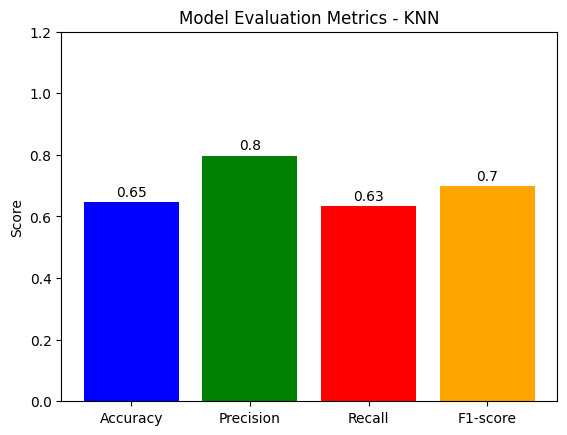

In [62]:
# Visualize model evaluation metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

bars = plt.bar(metrics, values, color=['blue', 'green', 'red', 'orange'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

plt.ylabel('Score')
plt.title('Model Evaluation Metrics - KNN')
plt.ylim(0, 1.2)
plt.show()